# CLIP-Dissect
**Keywords**: Neuron-level Interpretability, Network Dissection

**About the dataset**:

* We use the standard [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) here which contains 60k RGB images of size $32\times 32$ belonging to 100 classes.

**Agenda**:

* In this programming challenge, we will answer the following questions.
  * **Part 1**
    1. How many last layer neurons (out of 1000) are correctly described by CLIP-dissect? --> we can thus compute an accuracy of CLIP-dissect description.
    2. How many last layer neurons are not accurately described but somehow related
    3. How many last layer neurons are failure cases
    4. How would the above result change (question 1-3) when we change the parameters in CLIP-dissect? e.g. use a different D_probe, or CLIP encoder?

  * **Part 2**
    1. Please start playing with the notebook: fig11.ipynb. So far, we have been using CLIP-dissect to describe the last layer neuron, and now we'd like to also look into "intermediate layer" neurons in Resnet 50.
    
      (a) what does a Resnet 50 network look like? what is its architecture, and what does layer 1, 2, 3, 4 refer to?
      - Please show a figure of architecture and identify these layers.  
      - How many neurons are in layer 1, 2, 3, 4 respectively?

      (b) Let's dissect resnet 50 layer 1 and 4 similar to what we did on the last layer neuron.
      - Does the neuron description match the highly activated images? How many of them describe well / not so well but relevant / not accurate?  
      - Please think of a way to manage / save the result for future analysis.  


**Note:**
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.

In [1]:
# !!DO NOT EDIT!!
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect
!pip install ftfy regex
import os
os.chdir('CLIP-dissect')

import torch
import pandas as pd

import clip
import utils
import data_utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 98 (delta 10), reused 9 (delta 7), pack-reused 80
Receiving objects: 100% (98/98), 15.90 MiB | 18.99 MiB/s, done.
Resolving deltas: 100% (31/31), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 866.4 kB/s eta 0:00:00


# Part 1

### **1. Computing accuracy for neurons**

* Compare first description with ground truth class for each neuron.

In [2]:
# !!! YOUR CODE HERE !!!
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
d_probe = 'cifar100_train'
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi
# ids_to_check = [131, 132]

with open('data/imagenet_labels.txt', 'r') as f:
    ground_truth_labels = (f.read()).split('\n')

utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                             text_save_name, similarity_fn, device=device)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

acc_count = 0
for orig_id in range(len(similarities)):
    gt_class = ground_truth_labels[orig_id]
    first_sim, first_id = torch.topk(similarities[orig_id], k=1, largest=True)
    first_label = words[int(first_id)]
    # print(first_sim, first_id, first_label, gt_class)
    if gt_class == first_label:
        acc_count += 1

print("Number of last layer neurons accurately labeled: {}".format(acc_count))
print("Number of last layer neurons being labeled: {}".format(len(similarities)))
print("Acuracy of CLIP-dissect description: {}".format(acc_count / len(similarities)))

100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 83.2MiB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


100%|██████████| 169001437/169001437 [00:04<00:00, 34604733.87it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1000/1000 [00:00<00:00, 1404.48it/s]


torch.Size([1000, 1000])
Files already downloaded and verified
Number of last layer neurons accurately labeled: 462
Number of last layer neurons being labeled: 1000
Acuracy of CLIP-dissect description: 0.462


### **2. Computing number of related (but not accurate) last layer neurons**

* Which of the last layer neurons have the correct class in the top 3 descriptions, but are not accurate?
  * Look for descriptions where 2nd or 3rd description are the ground truth class.

In [3]:
sim_count = 0
for orig_id in range(len(similarities)):
    gt_class = ground_truth_labels[orig_id]
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    top_3 = []
    for i in range(1, len(vals)):
        top_3.append(words[int(ids[i])])
    # print(first_sim, first_id, first_label, gt_class)
    if gt_class in top_3:
        sim_count += 1

print("Number of last layer neurons that are somehow related: {}".format(sim_count))

Number of last layer neurons that are somehow related: 252


### **3. Computing failure cases in last layer neurons**

* Which of the last layer neurons were not accurately labeled?
  * Define failure case as the following:
      - ground truth class is not present in any of the top 3 descriptions generated

In [4]:
fail_count = 0
for orig_id in range(len(similarities)):
    gt_class = ground_truth_labels[orig_id]
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    top_3 = []
    for i in range(len(vals)):
        top_3.append(words[int(ids[i])])
    if gt_class not in top_3:
        fail_count += 1

print("Number of last layer neurons that were not accurately labeled: {}".format(fail_count))

Number of last layer neurons that were not accurately labeled: 286


### **4. Changing parameters**

* How would the above result change (question 1-3) when we change the parameters in CLIP-dissect? e.g. use a different D_probe, or CLIP encoder?


In [5]:
!bash dlbroden.sh

/content/CLIP-dissect/data /content/CLIP-dissect
--2023-11-06 06:59:11--  http://netdissect.csail.mit.edu/data/broden1_224.zip
Resolving netdissect.csail.mit.edu (netdissect.csail.mit.edu)... 128.52.131.63
Connecting to netdissect.csail.mit.edu (netdissect.csail.mit.edu)|128.52.131.63|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 937582103 (894M) [application/zip]
Saving to: ‘broden1_224.zip’

broden1_224.zip     100%[===================>] 894.15M  40.0MB/s    in 20s     

2023-11-06 06:59:32 (43.7 MB/s) - ‘broden1_224.zip’ saved [937582103/937582103]

/content/CLIP-dissect/data/broden1_224 /content/CLIP-dissect/data /content/CLIP-dissect
/content/CLIP-dissect/data /content/CLIP-dissect


In [8]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
d_probes = ['cifar100_train', 'broden']
similarity_fns = ["cos_similarity", "rank_reorder", "wpmi", "soft_wpmi"]
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'
save_dir = 'saved_activations'

with open('data/imagenet_labels.txt', 'r') as f:
    ground_truth_labels = (f.read()).split('\n')

with open(concept_set, 'r') as f:
      words = (f.read()).split('\n')

for similarity_fn in similarity_fns:
  for d_probe in d_probes:

    utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                          d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                          device = device, pool_mode=pool_mode, save_dir = save_dir)

    save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                      target_layer = target_layer, d_probe = d_probe,
                                      concept_set = concept_set, pool_mode=pool_mode,
                                      save_dir = save_dir)

    target_save_name, clip_save_name, text_save_name = save_names

    similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                text_save_name, eval("similarity.{}".format(similarity_fn)), device=device)

    pil_data = data_utils.get_data(d_probe)

    print("Current similarity function: {}".format(similarity_fn))
    print("Current d_probe: {}".format(d_probe))

    acc_count = 0
    for orig_id in range(len(similarities)):
        gt_class = ground_truth_labels[orig_id]
        first_sim, first_id = torch.topk(similarities[orig_id], k=1, largest=True)
        first_label = words[int(first_id)]
        # print("top label: {}, ground truth class: {}, accurate? {}" .format(first_label, gt_class, first_label == gt_class, "\n"))
        if gt_class == first_label:
            acc_count += 1

    print("Number of last layer neurons accurately labeled: {}".format(acc_count))
    print("Acuracy of CLIP-dissect description: {}".format(acc_count / len(similarities)))

    sim_count = 0
    for orig_id in range(len(similarities)):
        gt_class = ground_truth_labels[orig_id]
        vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
        top_3 = []
        for i in range(1, len(vals)):
            top_3.append(words[int(ids[i])])
        if gt_class in top_3:
            sim_count += 1

    print("Number of last layer neurons that are somehow related: {}".format(sim_count))

    fail_count = 0
    for orig_id in range(len(similarities)):
        gt_class = ground_truth_labels[orig_id]
        vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
        top_3 = []
        for i in range(len(vals)):
            top_3.append(words[int(ids[i])])
        if gt_class not in top_3:
            fail_count += 1

    print("Number of last layer neurons that were not accurately labeled: {}\n".format(fail_count))

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


Files already downloaded and verified
Current similarity function: cos_similarity
Current d_probe: cifar100_train
Number of last layer neurons accurately labeled: 87
Acuracy of CLIP-dissect description: 0.087
Number of last layer neurons that are somehow related: 89
Number of last layer neurons that were not accurately labeled: 824



100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


Current similarity function: cos_similarity
Current d_probe: broden
Number of last layer neurons accurately labeled: 52
Acuracy of CLIP-dissect description: 0.052
Number of last layer neurons that are somehow related: 95
Number of last layer neurons that were not accurately labeled: 853

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:17<00:00, 56.01it/s]


Files already downloaded and verified
Current similarity function: rank_reorder
Current d_probe: cifar100_train
Number of last layer neurons accurately labeled: 365
Acuracy of CLIP-dissect description: 0.365
Number of last layer neurons that are somehow related: 215
Number of last layer neurons that were not accurately labeled: 420



100%|██████████| 1000/1000 [00:23<00:00, 42.51it/s]


Current similarity function: rank_reorder
Current d_probe: broden
Number of last layer neurons accurately labeled: 581
Acuracy of CLIP-dissect description: 0.581
Number of last layer neurons that are somehow related: 199
Number of last layer neurons that were not accurately labeled: 220

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:00<00:00, 3843.25it/s]


Files already downloaded and verified
Current similarity function: wpmi
Current d_probe: cifar100_train
Number of last layer neurons accurately labeled: 237
Acuracy of CLIP-dissect description: 0.237
Number of last layer neurons that are somehow related: 214
Number of last layer neurons that were not accurately labeled: 549



100%|██████████| 1000/1000 [00:00<00:00, 2150.55it/s]


Current similarity function: wpmi
Current d_probe: broden
Number of last layer neurons accurately labeled: 493
Acuracy of CLIP-dissect description: 0.493
Number of last layer neurons that are somehow related: 219
Number of last layer neurons that were not accurately labeled: 288

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:00<00:00, 1394.84it/s]


torch.Size([1000, 1000])
Files already downloaded and verified
Current similarity function: soft_wpmi
Current d_probe: cifar100_train
Number of last layer neurons accurately labeled: 462
Acuracy of CLIP-dissect description: 0.462
Number of last layer neurons that are somehow related: 252
Number of last layer neurons that were not accurately labeled: 286



100%|██████████| 1000/1000 [00:00<00:00, 1397.12it/s]


torch.Size([1000, 1000])
Current similarity function: soft_wpmi
Current d_probe: broden
Number of last layer neurons accurately labeled: 701
Acuracy of CLIP-dissect description: 0.701
Number of last layer neurons that are somehow related: 155
Number of last layer neurons that were not accurately labeled: 144



I found that changing the similarity function and d_probe changed the accuracy of labels. Comparing CIFAR100 and Broden, we see that accuracy and similarity fluctuate based on both the similarity function and d_probe used. However, I could not test this with ImageNet as I didn't have the ImageNet data and didn't have my own copy of the ImageNet validation set.

In [7]:
clip_name = 'ViT-B/16'
target_name = 'resnet50'
target_layer = 'fc'
d_probes = ['cifar100_train', 'broden']
similarity_fns = ["cos_similarity", "rank_reorder", "wpmi", "soft_wpmi"]
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'
save_dir = 'saved_activations'

with open('data/imagenet_labels.txt', 'r') as f:
    ground_truth_labels = (f.read()).split('\n')

with open(concept_set, 'r') as f:
      words = (f.read()).split('\n')

d = {}
for d_probe in d_probes:
    col_name = d_probe
    col_data = []
    for similarity_fn in similarity_fns:
        utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                              d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                              device = device, pool_mode=pool_mode, save_dir = save_dir)

        save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                          target_layer = target_layer, d_probe = d_probe,
                                          concept_set = concept_set, pool_mode=pool_mode,
                                          save_dir = save_dir)

        target_save_name, clip_save_name, text_save_name = save_names

        similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                    text_save_name, eval("similarity.{}".format(similarity_fn)), device=device)

        pil_data = data_utils.get_data(d_probe)

        acc_count = 0
        for orig_id in range(len(similarities)):
            gt_class = ground_truth_labels[orig_id]
            first_sim, first_id = torch.topk(similarities[orig_id], k=1, largest=True)
            first_label = words[int(first_id)]
            # print("top label: {}, ground truth class: {}, accurate? {}" .format(first_label, gt_class, first_label == gt_class, "\n"))
            if gt_class == first_label:
                acc_count += 1
        col_data.append(acc_count / len(similarities))
    d[col_name] = col_data

acc_df = pd.DataFrame(data=d, index = similarity_fns)
acc_df


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:18<00:00, 52.99it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:00<00:00, 2603.23it/s]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1000/1000 [00:00<00:00, 1117.36it/s]


torch.Size([1000, 1000])
Files already downloaded and verified


100%|██████████| 1000/1000 [00:00<00:00, 1333.06it/s]


torch.Size([1000, 1000])


cifar100_train  broden
cos_similarity           0.087   0.052
rank_reorder             0.365   0.581
wpmi                     0.237   0.493
soft_wpmi                0.462   0.701

<Axes: >

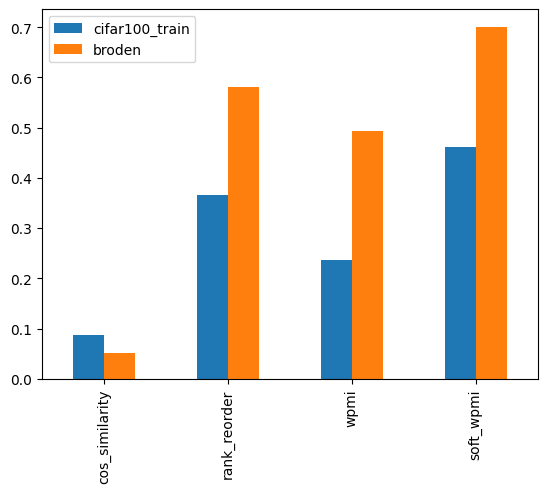

In [9]:
acc_df.plot.bar()

# Part 2

In [ ]:
# # Settings
# clip_name = 'ViT-B/16'
# target_name = 'resnet50'
# target_layer = 'layer1'
# d_probe = 'cifar100_train'
# concept_set = 'data/imagenet_labels.txt'
# batch_size = 200
# device = 'cuda'
# pool_mode = 'avg'

# save_dir = 'saved_activations'
# similarity_fn = similarity.soft_wpmi

In [ ]:
# # Run CLIP-Dissect
# utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
#                        d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
#                        device = device, pool_mode=pool_mode, save_dir = save_dir)

# with open(concept_set, 'r') as f:
#     words = (f.read()).split('\n')

# pil_data = data_utils.get_data(d_probe)

# save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
#                                   target_layer = target_layer, d_probe = d_probe,
#                                   concept_set = concept_set, pool_mode=pool_mode,
#                                   save_dir = save_dir)

# target_save_name, clip_save_name, text_save_name = save_names
# similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
#                                                                 text_save_name, similarity_fn, device=device)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 250/250 [02:46<00:00,  1.50it/s]


Files already downloaded and verified


100%|██████████| 256/256 [00:00<00:00, 1202.13it/s]

torch.Size([256, 1000])


In [10]:
# Settings
clip_name = 'ViT-B/16'
target_name = 'resnet50'
d_probe = 'cifar100_train'
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 256/256 [00:00<00:00, 1595.67it/s]


torch.Size([256, 1000])


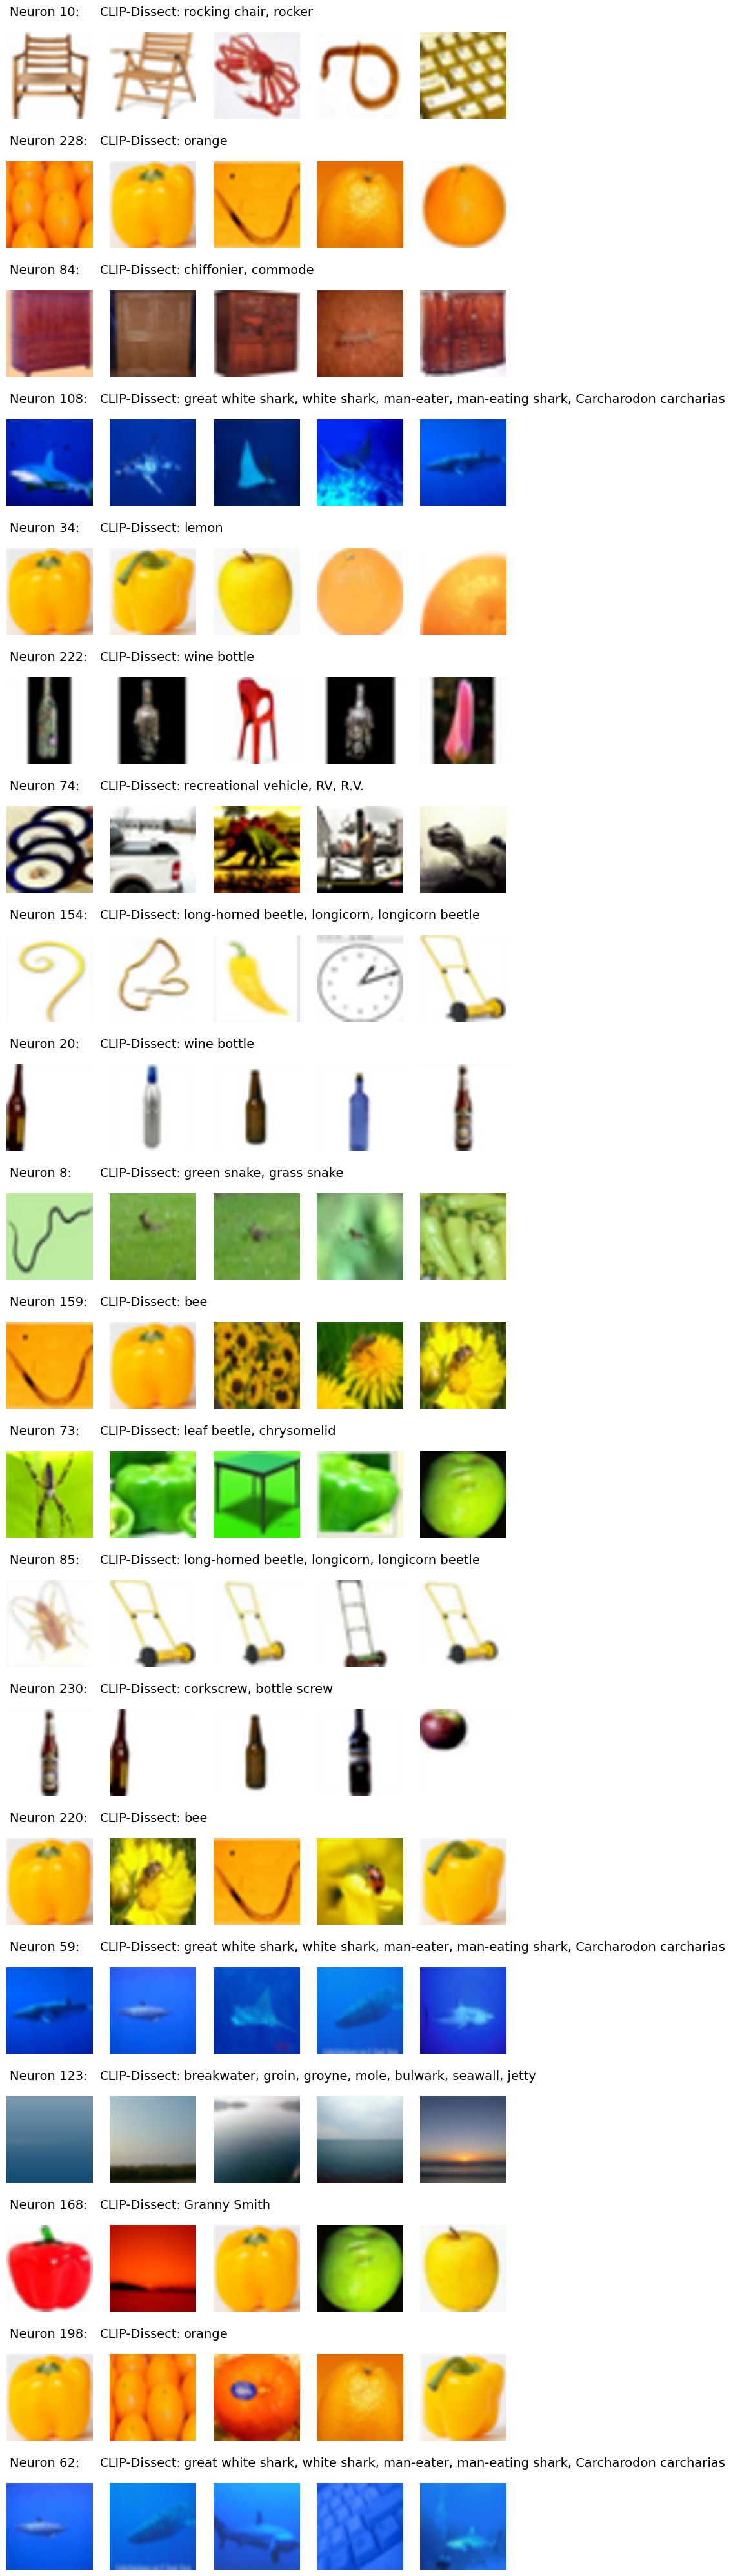

In [13]:
# Set layer to Layer 1
target_layer = 'layer1'

# Run CLIP-Dissect
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                text_save_name, similarity_fn, device=device)

# Visualize
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:20]
font_size = 14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

Layer 1 examples shows that neuron descriptions don't accurately match the highly activated images as well as the fully connected layer did. Some neurons definetely did better than others though.

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 250/250 [02:32<00:00,  1.64it/s]


Files already downloaded and verified


100%|██████████| 2048/2048 [00:01<00:00, 1219.74it/s]


torch.Size([2048, 1000])


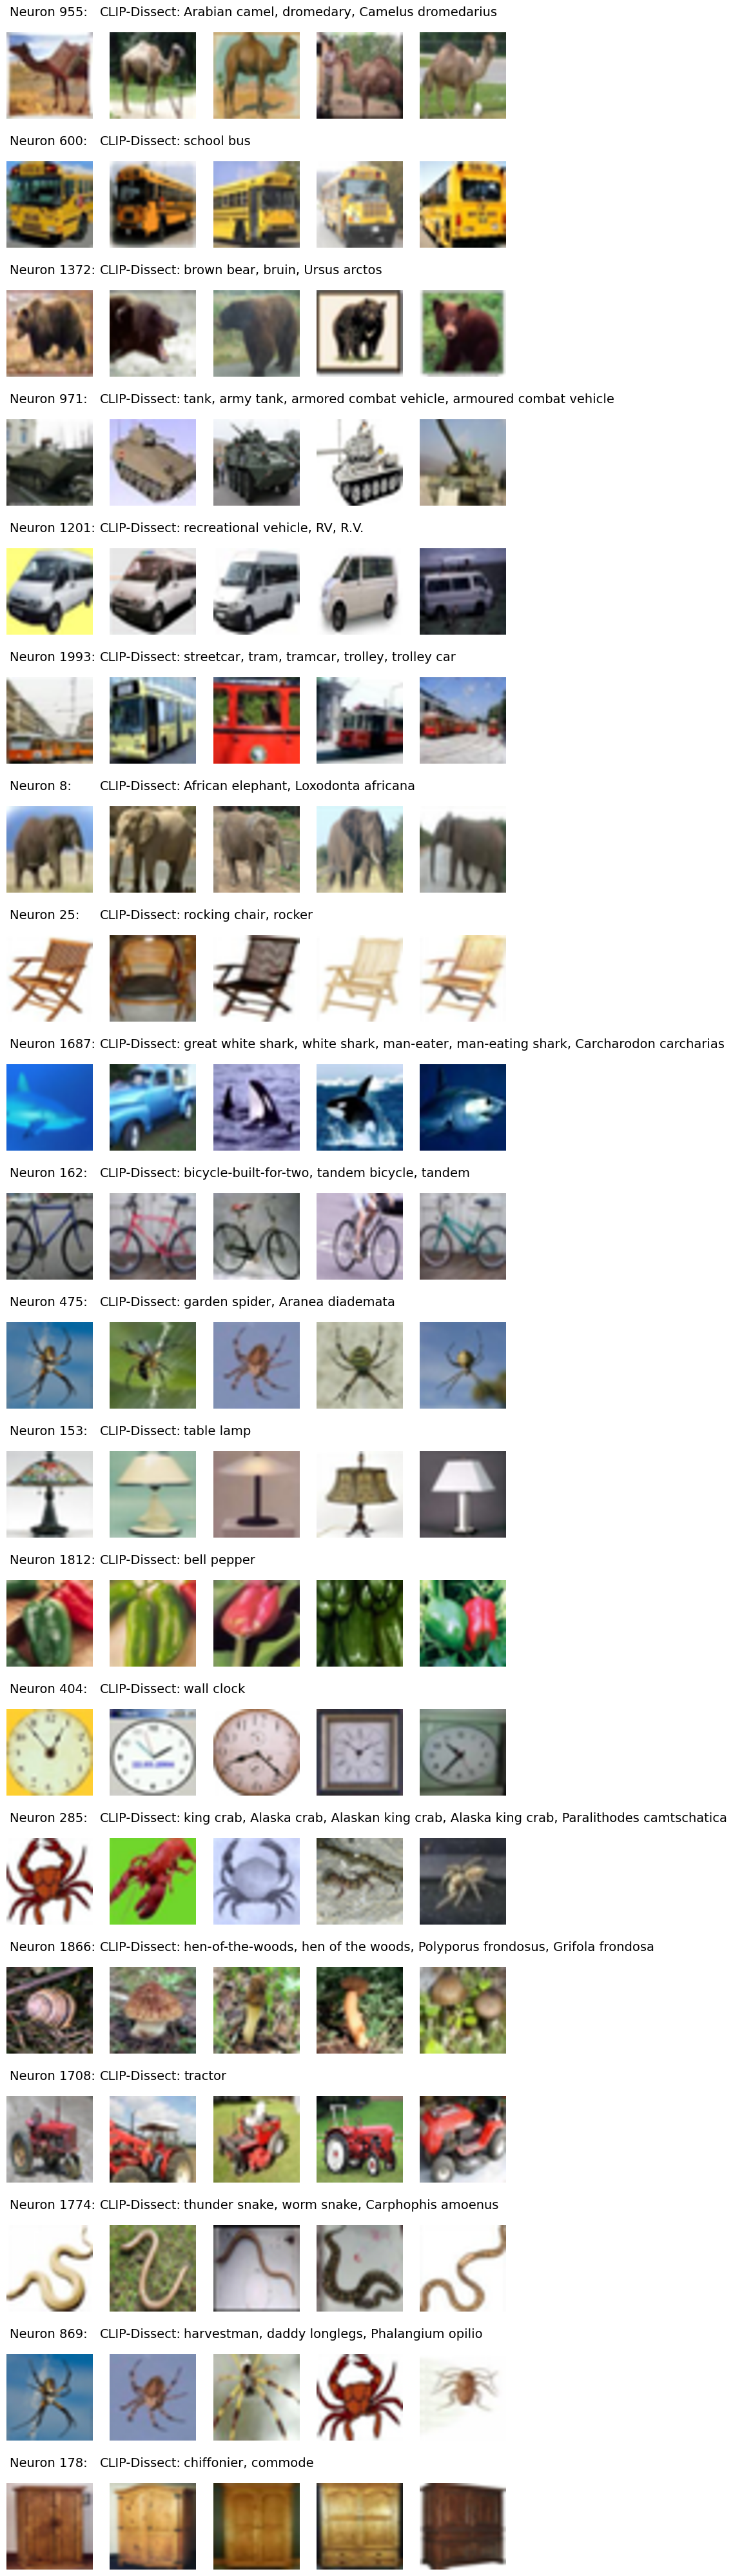

In [14]:
# Set layer to Layer 4
target_layer = 'layer4'

# Run CLIP-Dissect
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                text_save_name, similarity_fn, device=device)

# Visualize
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:20]
font_size = 14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()

Layer 4 examples shows that neuron descriptions are very close to accurately matching the highly activated images, almost as well as the fully connected layer did. Most images have the correct description.

---
---